In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as MG
from tqdm import tqdm

In [2]:
def Initial_miu(X, k):
    miu = [np.random.randint(X.shape[1])]
    while len(miu) < k:
        dis = np.ones(X.shape[1]) * np.infty
        for i in range(X.shape[1]):
            if i in miu:
                continue;
            for j in miu:
                dis[i] = min(dis[i], np.sum((X[:, i] - X[:, j]) ** 2))
        miu.append(np.argmax(dis))
    for i in range(k):
        miu[i] = X[:, [i]].copy()
    return np.array(miu)

def KE(X, miu):
    cluster = np.zeros((0, X.shape[1]))
    for i in range(miu.shape[0]):
        cluster = np.vstack([cluster, np.sum((X - miu[i]) ** 2, axis=0)])
    return np.argmin(cluster, axis=0)

def K_means(X, k, echo=False):
    threshold = 1e-6
    n = 0
    
    #初始化均值
    miu = Initial_miu(X, k)
    
    while 1:
        temp = miu.copy()
        #计算类别
        cluster = KE(X, miu)
        
        #更新均值
        for i in range(miu.shape[0]):
            miu[i] = np.average([X[:, [j]] for j in range(X.shape[1]) if cluster[j] == i], axis=0)
        
        if np.sum((temp - miu) ** 2) < threshold:
            break
        
        if(echo and n > echo):
            break
        
        n += 1
    
    return miu

In [3]:
def GMME(X, k, alpha, miu, sigma):
    gama = np.zeros((X.shape[1], k))
    for j in range(X.shape[1]):
        for i in range(k):
            gama[j][i] = alpha[i] * MG.pdf(X[:, j], miu[i].flatten(), sigma[i])
    gama /= np.sum(gama, axis=1).reshape((X.shape[1], 1))
    return gama

def GMM(X, k, echo=100000, echo2=False):
    #X(m, n)
    #初始化
    miu = K_means(X, k, echo2)
    sigma = np.array([np.eye(X.shape[0]) for _ in range(k)])
    alpha = np.ones(k) / k
    
    for t in tqdm(range(echo)):
        #E步
        gama = GMME(X, k, alpha, miu, sigma)
        
        #M步
        alpha = np.sum(gama, axis=0)
        sigma = np.zeros_like(sigma)
        miu = np.zeros_like(miu)
        for i in range(k):
            for j in range(X.shape[1]):
                miu[i] += gama[j][i] * X[:, [j]]
            miu[i] /= alpha[i]
            for j in range(X.shape[1]):
                temp = X[:, [j]] - miu[i]
                sigma[i] += gama[j][i] * temp.dot(temp.T)
            sigma[i] /= alpha[i]
        alpha /= X.shape[1]
    
    return alpha, miu, sigma

In [4]:
def draw(X, Y):
    color = ['r', 'y', 'b']
    shape = ['o', 'x', '+']
    for i in range(X.shape[1]):
        plt.scatter(X[0, i], X[1, i], marker=shape[Y[i]], color=color[Y[i]])
    plt.show()

In [5]:
n = 300
num = 1
miu_real = [np.array([-num, -num]), np.array([num, -num]), np.array([0, num])]
sigma_real = [np.eye(2) * np.random.rand() for _ in range(3)]
alpha_real = [0.2, 0.5]
Y_real = (np.random.rand(n) > alpha_real[0]).astype('int') + (np.random.rand(n) > alpha_real[1]).astype('int')
X = []
for i in range(n):
    idx = Y_real[i]
    X.append(np.random.multivariate_normal(miu_real[idx], sigma_real[idx]))
X = np.array(X).T

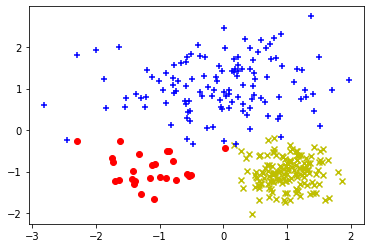

In [6]:
draw(X, Y_real)

In [7]:
k = 3

In [8]:
miu1 = K_means(X, k)

In [9]:
Y1 = KE(X, miu1)

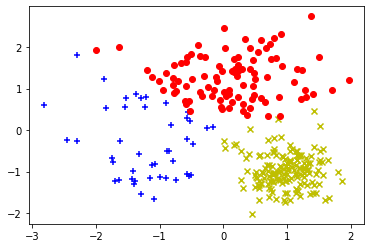

In [10]:
draw(X, Y1)

In [11]:
alpha, miu, sigma = GMM(X, k, 50)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.96it/s]


In [12]:
Y2 = np.argmax(GMME(X, k, alpha, miu, sigma), axis=1)

In [13]:
print(alpha_real)
print(alpha)

[0.2, 0.5]
[0.38992172 0.49839234 0.11168593]


In [14]:
print(miu_real)
print(miu)

[array([-1, -1]), array([ 1, -1]), array([0, 1])]
[[[ 0.05622333]
  [ 1.07949114]]

 [[ 0.9961998 ]
  [-1.01344529]]

 [[-1.28859858]
  [-0.57686972]]]


In [15]:
print(sigma_real)
print(sigma)

[array([[0.15401791, 0.        ],
       [0.        , 0.15401791]]), array([[0.12400811, 0.        ],
       [0.        , 0.12400811]]), array([[0.63992835, 0.        ],
       [0.        , 0.63992835]])]
[[[ 0.61872913  0.03126732]
  [ 0.03126732  0.43276116]]

 [[ 0.11296431  0.0063979 ]
  [ 0.0063979   0.12611463]]

 [[ 0.34984941 -0.18321799]
  [-0.18321799  0.65368268]]]


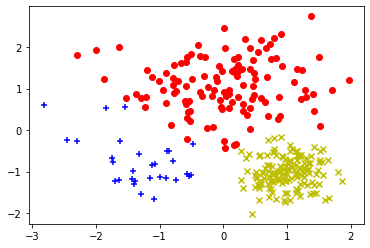

In [16]:
draw(X, Y2)

In [17]:
import pandas as pd

In [18]:
datapath = 'Rice_Osmancik_Cammeo_Dataset.csv'
data = pd.read_csv(datapath)

In [24]:
#处理数据，将数据存入矩阵中
attributes = data.columns
Y = list(data[attributes[-1]])
for i in range(len(Y)):
     Y[i] = 1 if Y[i] == 'Cammeo' else 0
Y = np.array(Y)
Y = Y.reshape((len(Y), 1))
attributes = attributes[:-1]
X_uci = np.zeros((len(Y), 0))
for attribute in attributes:
    X_uci = np.hstack([X_uci, np.array(data[attribute]).reshape(len(Y), 1)])
X_uci = (X_uci - np.min(X_uci, axis=0)) / (np.max(X_uci, axis=0) - np.min(X_uci, axis=0))
X_uci = X_uci.T
print(X_uci.shape)

(7, 3810)


In [25]:
k_uci = 2
alpha_uci, miu_uci, sigma_uci = GMM(X_uci, k_uci, 50)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:16<00:00,  1.52s/it]


In [27]:
Y_uci = np.argmax(GMME(X_uci, k_uci, alpha_uci, miu_uci, sigma_uci), axis=1)

In [45]:
neg = X_uci.T[(Y==0).flatten()].T
pos = X_uci.T[(Y==1).flatten()].T

In [46]:
print([np.average(pos, axis=1), np.average(neg, axis=1)])

[array([0.5819303 , 0.67780122, 0.64231117, 0.60893771, 0.72501644,
       0.59523796, 0.42351801]), array([0.35194363, 0.37135988, 0.33092909, 0.51961286, 0.57993619,
       0.35834966, 0.47405267])]


In [47]:
print(miu_uci)

[[[0.5475837 ]
  [0.64250895]
  [0.61547313]
  [0.57793027]
  [0.73206365]
  [0.55975932]
  [0.42061587]]

 [[0.35076753]
  [0.35907053]
  [0.30920285]
  [0.53724553]
  [0.54979478]
  [0.35724204]
  [0.48500971]]]


In [48]:
print(np.cov(pos))
print()
print(np.cov(neg))

[[ 0.01282604  0.01236099  0.00981268  0.01075683 -0.00159672  0.01300398
   0.00157676]
 [ 0.01236099  0.01372367  0.01201759  0.00833073  0.00124411  0.01265615
  -0.00093275]
 [ 0.00981268  0.01201759  0.01215119  0.00432064  0.00396531  0.00996339
  -0.00097965]
 [ 0.01075683  0.00833073  0.00432064  0.01241889 -0.00579671  0.01093417
   0.00296345]
 [-0.00159672  0.00124411  0.00396531 -0.00579671  0.00613934 -0.00162518
  -0.00250086]
 [ 0.01300398  0.01265615  0.00996339  0.01093417 -0.00162518  0.01324884
   0.00145011]
 [ 0.00157676 -0.00093275 -0.00097965  0.00296345 -0.00250086  0.00145011
   0.05109478]]

[[ 0.0084091   0.00901939  0.00680862  0.00822557 -0.00164826  0.00854754
   0.00033203]
 [ 0.00901939  0.01132993  0.00962202  0.00675856  0.00185804  0.00925804
  -0.00181338]
 [ 0.00680862  0.00962202  0.00997399  0.0024199   0.00589514  0.00689157
  -0.00217744]
 [ 0.00822557  0.00675856  0.0024199   0.01219901 -0.00863117  0.00842571
   0.00252458]
 [-0.00164826  0.00

In [49]:
print(sigma_uci)

[[[ 0.01798309  0.01805533  0.01436265  0.01516998 -0.00214361
    0.01835414  0.00177098]
  [ 0.01805533  0.01970937  0.01643017  0.01371333 -0.00010292
    0.01856315 -0.00034671]
  [ 0.01436265  0.01643017  0.01506527  0.00914278  0.002132
    0.01467177 -0.00029386]
  [ 0.01516998  0.01371333  0.00914278  0.0153959  -0.00509774
    0.01551872  0.00272189]
  [-0.00214361 -0.00010292  0.002132   -0.00509774  0.00448189
   -0.00220473 -0.0018953 ]
  [ 0.01835414  0.01856315  0.01467177  0.01551872 -0.00220473
    0.01879786  0.00166176]
  [ 0.00177098 -0.00034671 -0.00029386  0.00272189 -0.0018953
    0.00166176  0.05224083]]

 [[ 0.00902782  0.00934428  0.00665067  0.00942381 -0.00271244
    0.00918086  0.00058912]
  [ 0.00934428  0.01069073  0.00807124  0.00871834 -0.00077724
    0.00958628 -0.00098971]
  [ 0.00665067  0.00807124  0.00721632  0.00465475  0.00221192
    0.00674195 -0.00088572]
  [ 0.00942381  0.00871834  0.00465475  0.01221866 -0.00711824
    0.00963994  0.00178865]


In [50]:
print([pos.shape[1] / len(Y), neg.shape[1] / len(Y)])

[0.42782152230971127, 0.5721784776902887]


In [51]:
print(alpha_uci)

[0.5059002 0.4940998]
